## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera calibration using chessboard images

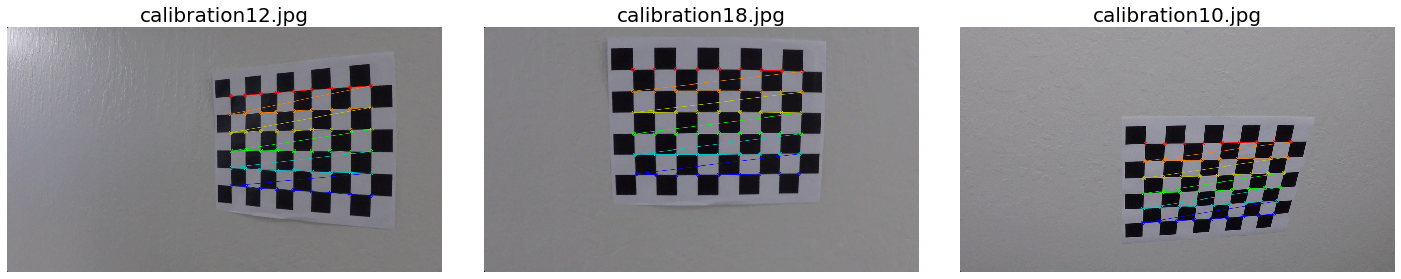

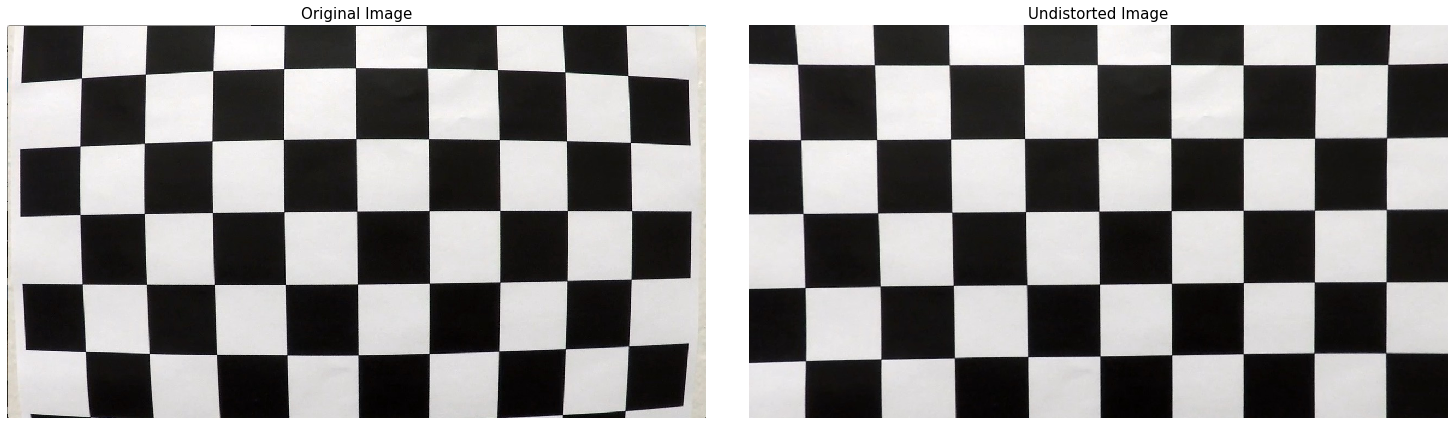

In [1]:
# clear all the variables used
%reset -f
%run advanced_lane_finder.py
%matplotlib inline

def plot_corner_marked_image(camera_calibrator_object):
    image_list = camera_calibrator_object.get_camera_calib_image_list()
    valid_indexes = camera_calibrator_object.get_valid_indexes()
    index_list = random.sample(range(0,  len(valid_indexes)), 3)
    f, ax = plt.subplots(1, 3, figsize=(20, 9))
    f.tight_layout()
    for ax_run, each_ax in enumerate(ax):
        image_name = image_list[valid_indexes[index_list[ax_run]]]
        fname = os.path.split(image_name)[-1]
        cur_image = cv2.imread(image_name)
        ret, corners = camera_calibrator_object.get_chessboard_corners(valid_indexes[index_list[ax_run]])
        cur_image = cv2.drawChessboardCorners(cur_image, (camera_calibrator_object.nx, camera_calibrator_object.ny),
                                              corners, ret)
        each_ax.imshow(cv2.cvtColor(cur_image,cv2.COLOR_BGR2RGB))
        each_ax.set_title(fname, fontsize=20)
        each_ax.axis("off")

def plot_dist_undist_image(dist_image, undist_image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(dist_image,cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=15)
    ax1.axis("off")
    ax2.imshow(cv2.cvtColor(undist_image,cv2.COLOR_BGR2RGB))
    ax2.axis("off")
    ax2.set_title('Undistorted Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Make a list of calibration images
camera_calib_images = glob.glob('./camera_cal/calibration*.jpg')
nx = 9 # number of inner corners of the chess board in x diretcion
ny = 6  # number of inner corners of the chess board in y diretcion
camera_calibrator_object = CameraCalibrator(camera_calib_images, nx, ny)
camera_calibrator_object.calibrate()
# plot corner marked images
plot_corner_marked_image(camera_calibrator_object)
# plot original and undistorted images
## Make a list of calibration images
test_image = './camera_cal/calibration1.jpg'
org_img = cv2.imread(test_image)
undistorted_image = camera_calibrator_object.undistort_the_image(org_img)
plot_dist_undist_image(org_img, undistorted_image)

###  Question 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Answer: The First step was to determine object point which is a 3d point in real world space and image point which is a 2d point in an image plane. To determine object points, we assume that the chessboard is kept on a level plane (z=0) and the number of inside corners in the x direction is 9 and number of inside corners in the y direction 6. The inside corners can easily be determined of the chessboard kept on a level plane which constitutes the object points. To determine the image points we browse through the camera calibration images and with the help of OpenCV we determine the inside corners in these camera calibration images. These images with marked corners are displayed above.

After obtaining the real world space coordinates (object points) and image coordinates (image points), using the OpenCV calibrateCamera function we determine camera calibration parameters. Using these parameters, un distorted image is obtained by using OpenCV function undistort. One of the examples of distorted and undistorted images is shown above.

 ### Perspective transform

Sorce Points: 
[[ 575.  460.]
 [ 175.  720.]
 [1100.  720.]
 [ 700.  460.]]
Dest Points: 
[[300.   0.]
 [300. 720.]
 [980. 720.]
 [980.   0.]]


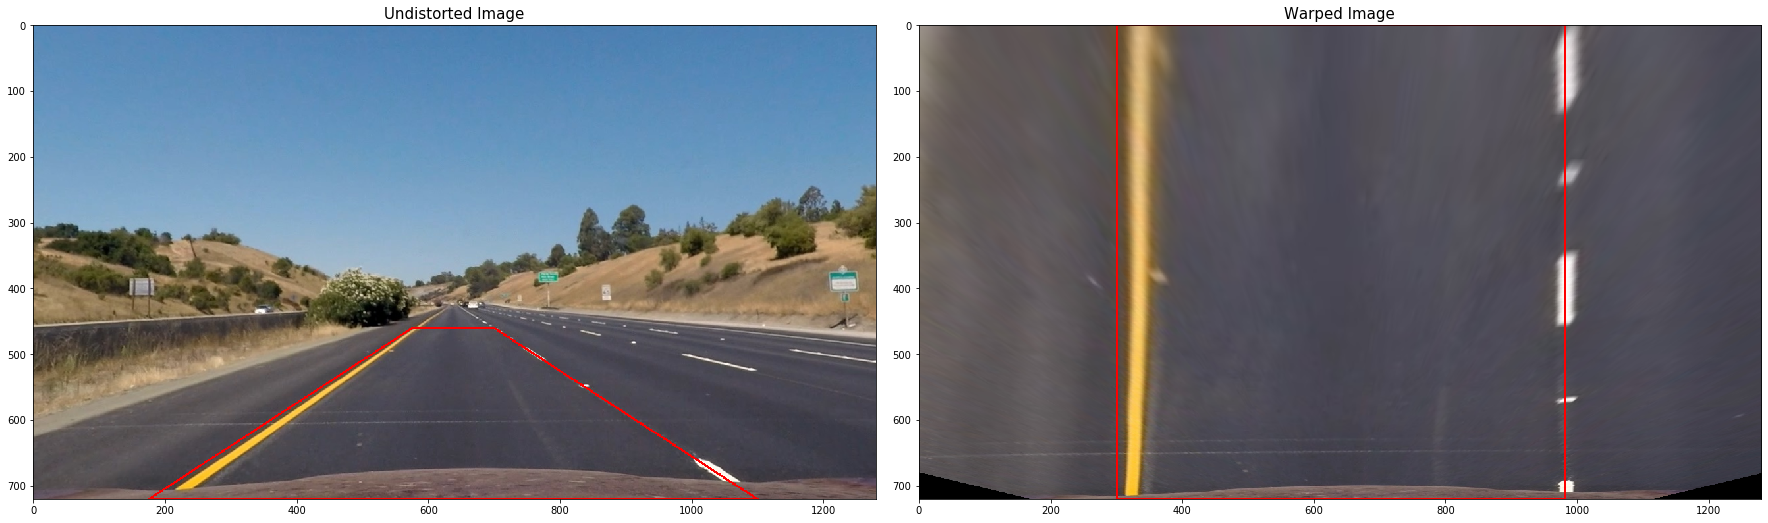

In [2]:
# clear all the variables used
%reset -f
%run advanced_lane_finder.py
%matplotlib inline

org_img = cv2.imread('./test_images/straight_lines1.jpg')
camera_calib_images = glob.glob('./camera_cal/calibration*.jpg')
nx = 9 # number of inner corners of the chess board in x diretcion
ny = 6  # number of inner corners of the chess board in y diretcion
camera_calibrator_object = CameraCalibrator(camera_calib_images, nx, ny)
camera_calibrator_object.calibrate()
undistorted_image = camera_calibrator_object.undistort_the_image(org_img)
image_size_y, image_size_x, _ =  undistorted_image.shape
pts = np.array([[575, image_size_y/2.0 + 100], 
                [175, image_size_y],
                [1100, image_size_y],
                [700, image_size_y/2.0 + 100]], np.float32)
b_view_transformer_obj = BirdViewTranformer(undistorted_image, pts)
birds_view_image = b_view_transformer_obj.change_to_birds_eye_view(undistorted_image)
cv2.polylines(birds_view_image, [np.int32(b_view_transformer_obj.dst_points)], True, (0,0,255), 2)
print('Sorce Points: \n' + np.array_str(b_view_transformer_obj.src_points))
print('Dest Points: \n' + np.array_str(b_view_transformer_obj.dst_points))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
pts = pts.reshape((-1,1,2))
cv2.polylines(undistorted_image,[np.int32(b_view_transformer_obj.src_points)],True,(0,0,255), 2)
ax1.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(cv2.cvtColor(birds_view_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

#### Question 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

Answer: An example of the transformation is shown above. The image used to find the transform is straight_lines1.jpg from test folder. The source points and destination points were defined. The source points are points on the undistorted image and destination points are on the transformed image. Both these used points are printed above.

```python
self.src_points = np.array([[575, image_size_y/2.0 + 100], 
                            [175, image_size_y],
                            [1100, image_size_y],
                            [700, image_size_y/2.0 + 100]], np.float32)
self.dst_points = np.array([[offset, 0],
                            [offset, image_size_y],
                            [image_size_x-offset, image_size_y],
                            [image_size_x-offset, 0]], np.float32)
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 575, 460      | 300, 0        | 
| 175, 720      | 300, 720      |
| 1100, 720     | 980, 720      |
| 700, 460      | 980, 0        |

Once these points were defined, then both transforms from source points to destination points and vice versa were calculated using Opencv function warpPerspective.


## Use color transforms, gradients, etc., to create a thresholded binary image

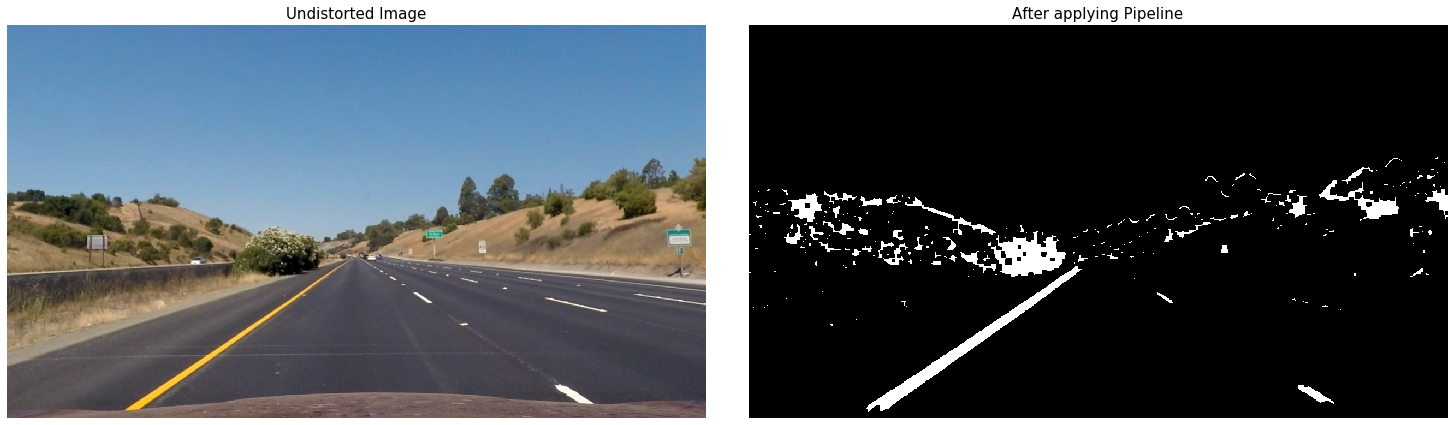

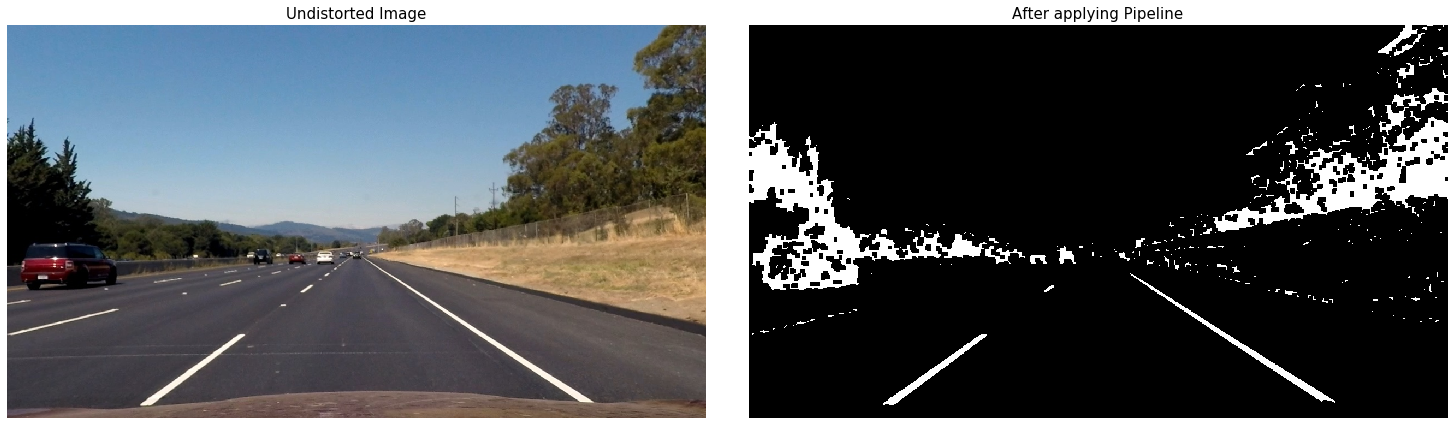

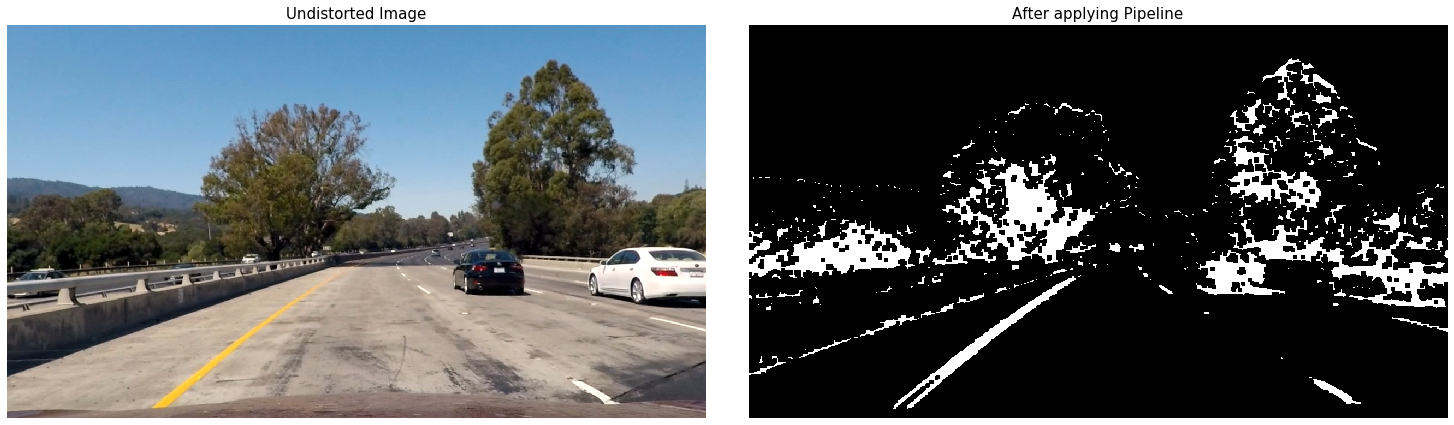

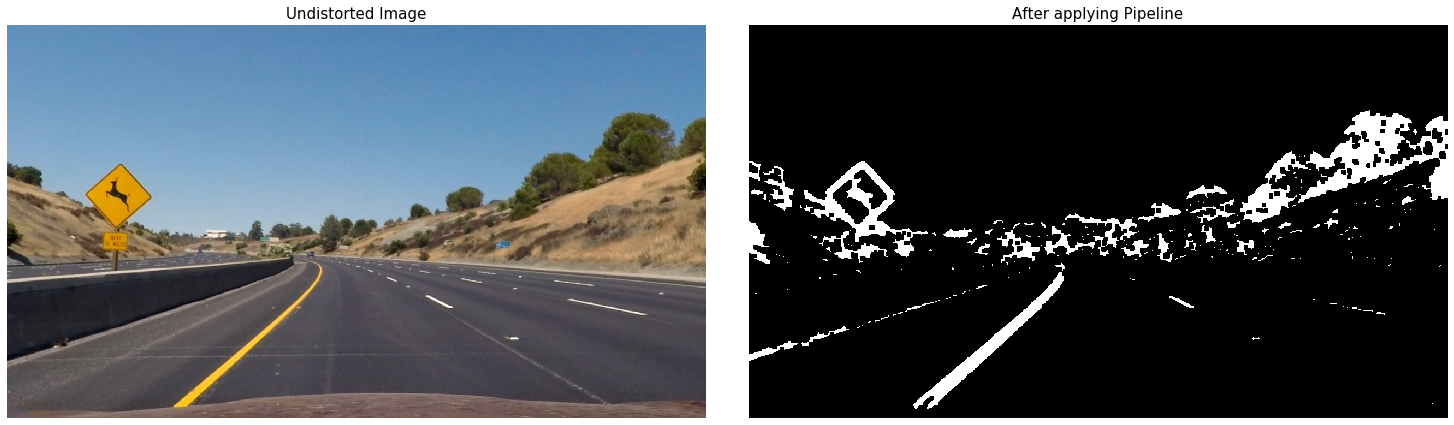

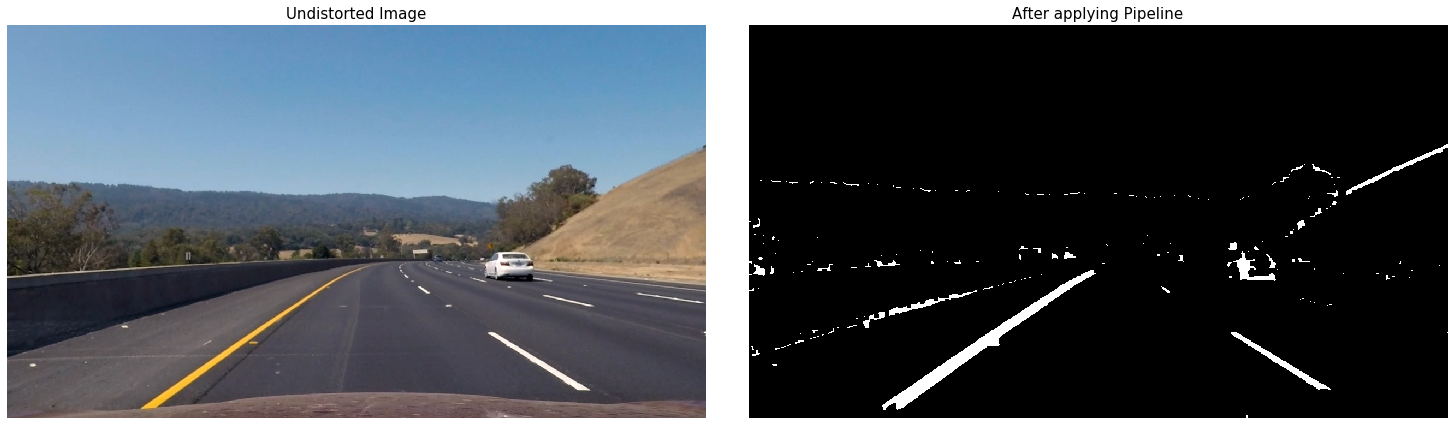

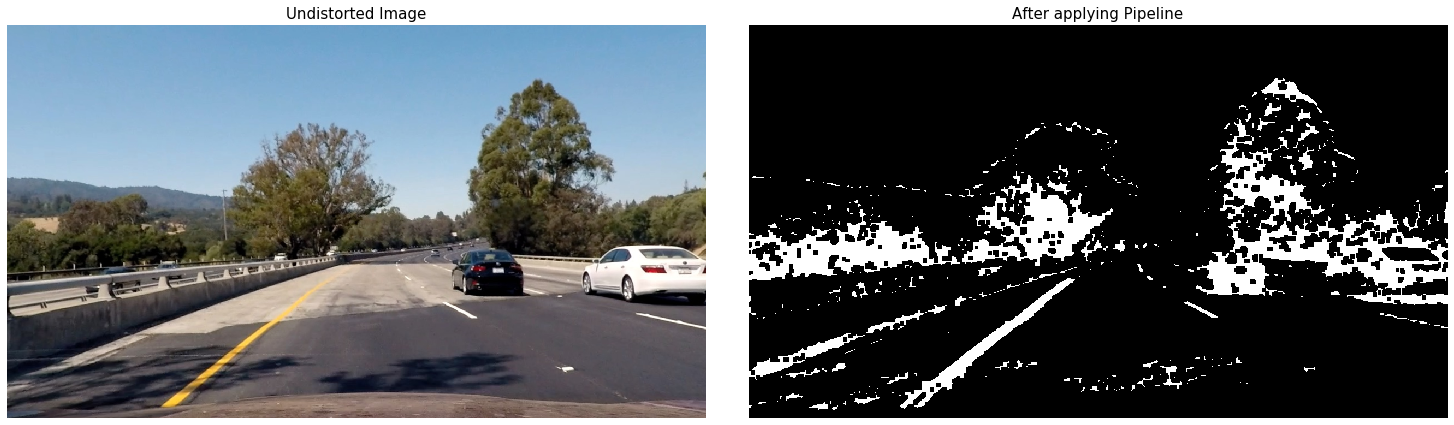

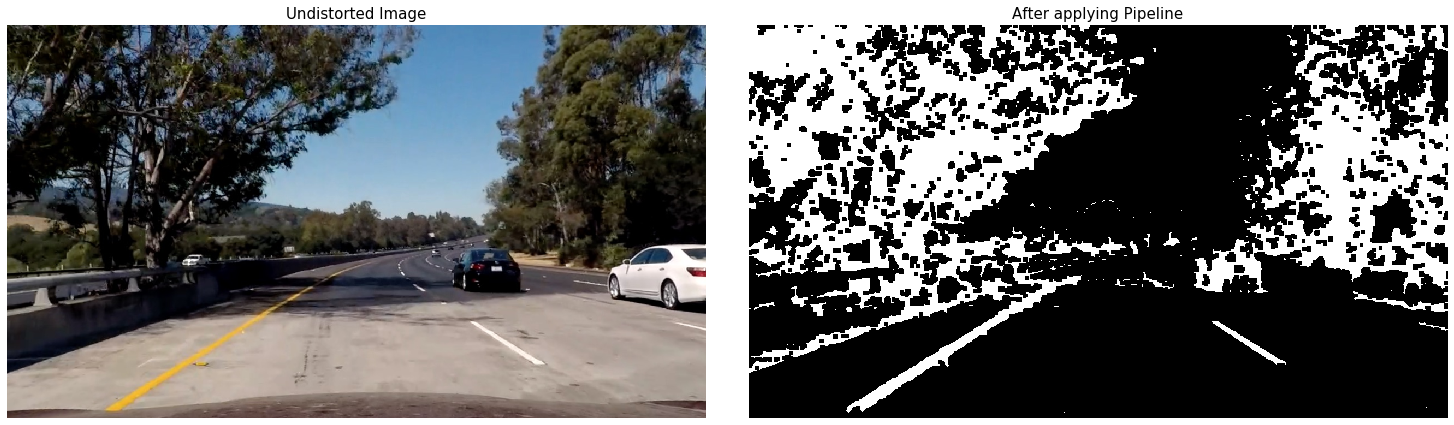

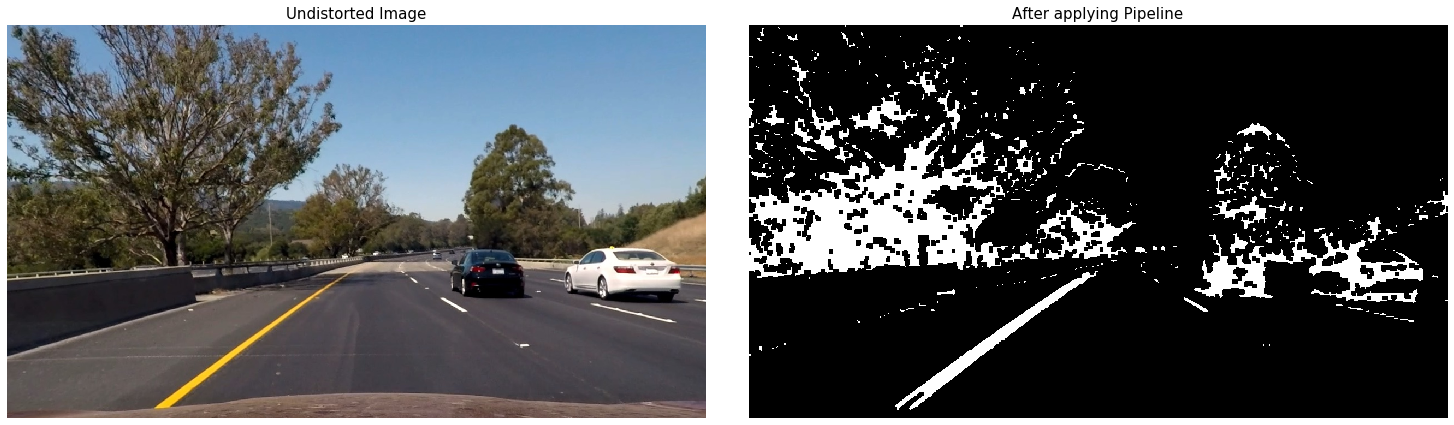

In [3]:
# clear all the variables used
%reset -f
%run advanced_lane_finder.py
%matplotlib inline

def plot_post_processing_image(org_image, post_image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(org_image,cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=15)
    ax1.axis("off")
    ax2.imshow(post_image,cmap='gray')
    ax2.axis("off")
    ax2.set_title('After applying Pipeline', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
test_images = glob.glob('./test_images/*.jpg')
camera_calib_images = glob.glob('./camera_cal/calibration*.jpg')
nx = 9 # number of inner corners of the chess board in x diretcion
ny = 6  # number of inner corners of the chess board in y diretcion
camera_calibrator_object = CameraCalibrator(camera_calib_images, nx, ny)
camera_calibrator_object.calibrate()
for each_test_image in test_images:
    undistorted_image = camera_calibrator_object.undistort_the_image(cv2.imread(each_test_image))
    binary_image = pipeline(undistorted_image)
    plot_post_processing_image(undistorted_image, binary_image)


#### Question 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
Answer: Examples of binary images obtained after applying the pipeline are shown above.
The code is implemented in the function pipeline in file advanced_lane_finder.py.
```python
image_copy = cv2.GaussianBlur(image_copy,(3,3),0)
hls = cv2.cvtColor(image_copy, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
# x - vertical lines in the image
# y - horizontal line in the image
kernel_size = 5
abs_sobelx_out = abs_sobel_thresh(s_channel, kernel_size, 'x', 20, 100)
abs_sobely_out = abs_sobel_thresh(s_channel, kernel_size, 'y', 20, 100)
mag_sobel = mag_thresh(s_channel, kernel_size, mag_thresh=(20, 100))
dir_sobel = dir_threshold(s_channel, kernel_size, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_sobel)
combined[((abs_sobelx_out == 1) & (abs_sobely_out == 1)) | ((mag_sobel == 1) & (dir_sobel == 1))] = 1
morph_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, morph_struct, iterations=3)
```
Pipeline:
* Perform Gaussian Blur to remove noises in the image
* Transform the image from RGB to HLS channel and extract Saturation channel. 
* Combination of absolute, magnitude and direction thresholds were applied on s channel.
* Finally on the resultant image, morphology operation of closing is applied to neglect the unwanted detection.


### Pipeline (Image)   

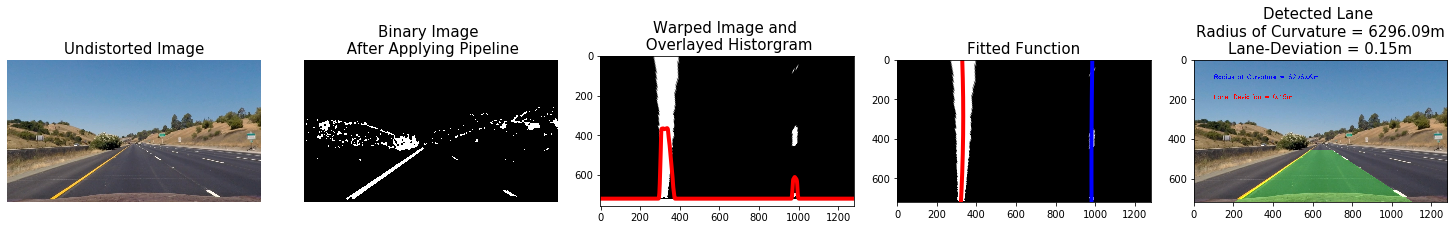

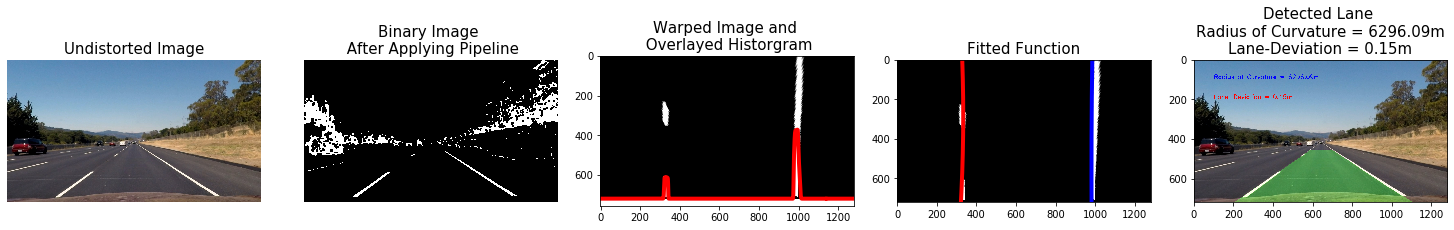

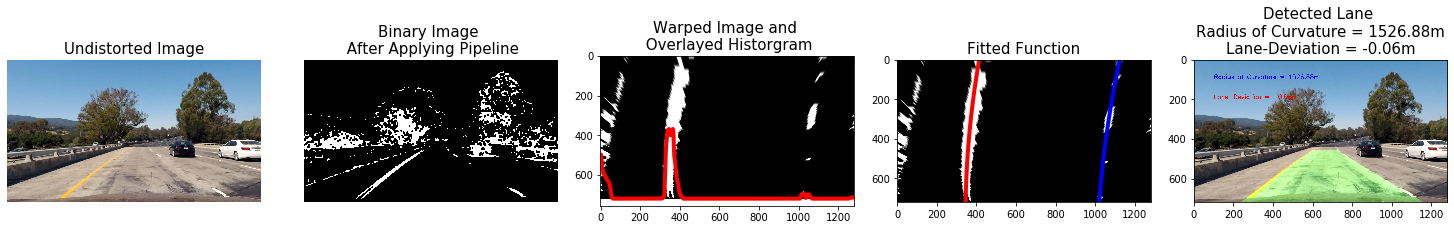

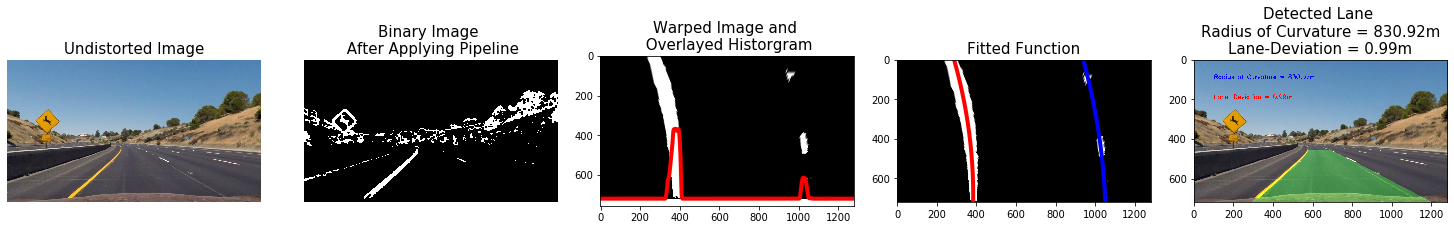

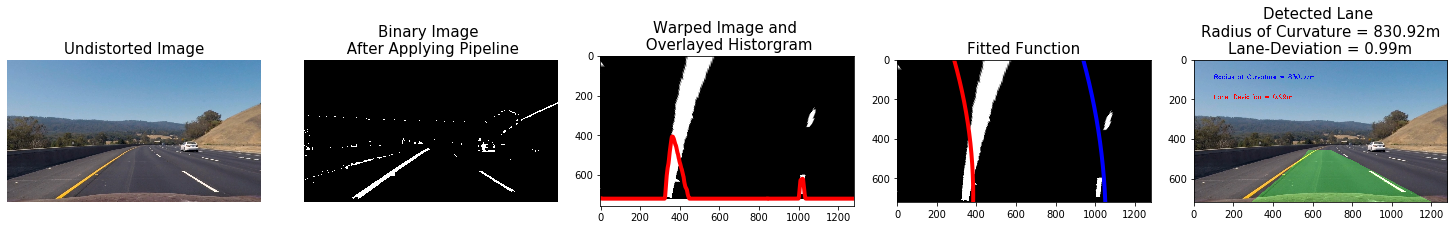

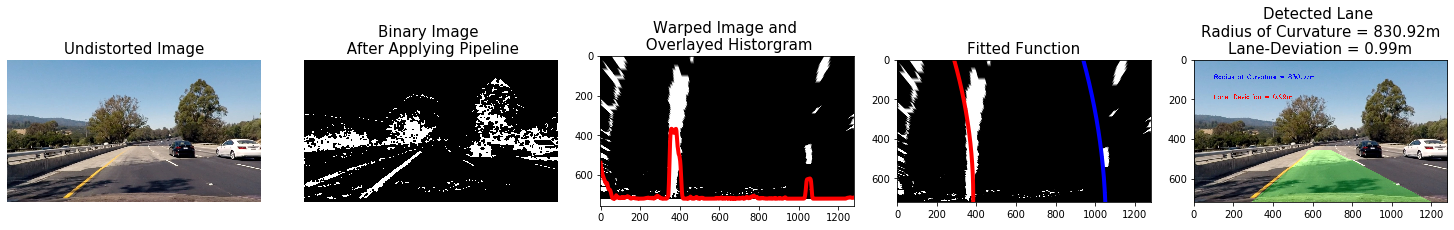

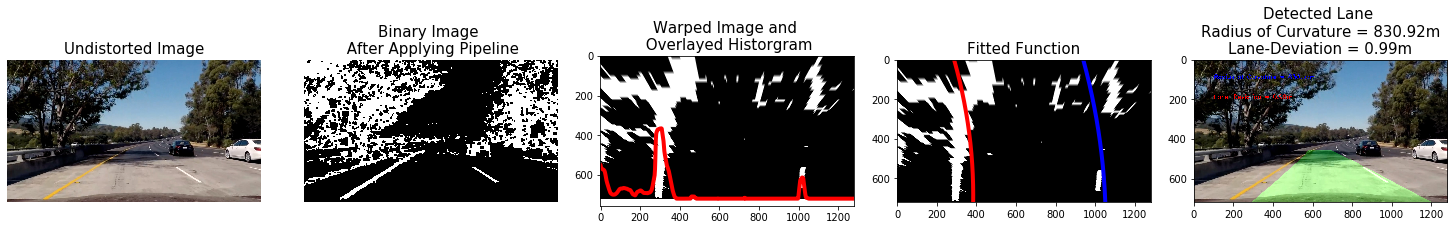

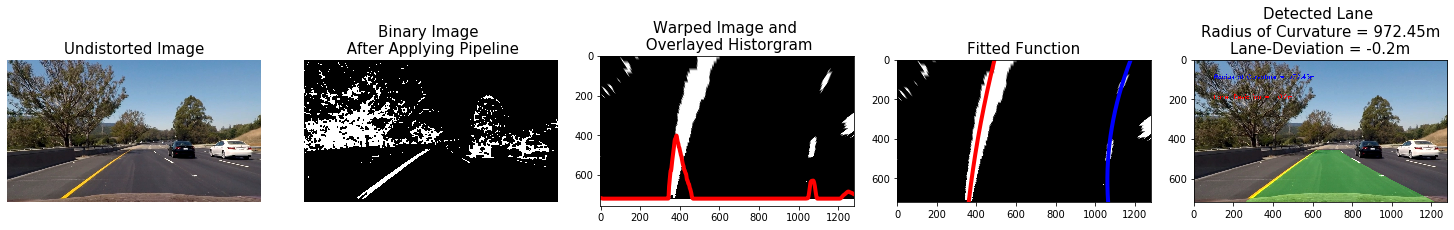

In [4]:
# clear all the variables used
%reset -f
%run advanced_lane_finder.py
%matplotlib inline

def plot_warped_image(undist_img, binary_image, after_warp, left_fitx, right_fitx, newwarp, lane_stats):
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
    f.tight_layout()
    # axis 1 plot
    ax1.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=15)
    ax1.axis("off")
    # axis 2 plot
    ax2.imshow(binary_image, cmap='gray')
    ax2.axis("off")
    ax2.set_title('Binary Image \n After Applying Pipeline', fontsize=15)
    # axis 3 plot
    ax3.imshow(after_warp, cmap='gray')
    ax3.set_title('Warped Image and \n Overlayed Historgram', fontsize=15)
    histogram = np.sum(after_warp[int(after_warp.shape[0]/2):,:], axis=0)
    histogram = after_warp.shape[0] - histogram
    ax3.plot(histogram, color='red', linewidth=4)
    #axis 4 plot
    ploty = np.linspace(0, after_warp.shape[0]-1, after_warp.shape[0] )
    ax4.imshow(after_warp, cmap='gray')
    ax4.set_title('Fitted Function', fontsize=15)
    ax4.plot(left_fitx, ploty, color='red', linewidth=4)
    ax4.plot(right_fitx, ploty, color='blue', linewidth=4)
    ax4.set_xlim(0, after_warp.shape[1])
    ax4.set_ylim(after_warp.shape[0], 0)
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    rad_curv = round((lane_stats[0] + lane_stats[1])/2.0, 2)
    lane_dev = round(lane_stats[2], 2)
    cv2.putText(result, 'Radius of Curvature = ' + str(rad_curv) + 'm',
               (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.0,
               (255,0,0), 2)
    cv2.putText(result, 'Lane-Deviation = ' + str(lane_dev) + 'm',
               (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1.0,
               (0,0,255), 2)
    text = ('Radius of Curvature = ' + str(rad_curv) + 'm' + '\n' + 
            'Lane-Deviation = ' + str(lane_dev) + 'm')
    ax5.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
    ax5.set_title('Detected Lane \n' + text, fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# pipeline for test images
test_images = glob.glob('./test_images/*.jpg')
birdview_mapper_img = cv2.imread('./test_images/straight_lines1.jpg')
camera_calib_images = glob.glob('./camera_cal/calibration*.jpg')
nx = 9 # number of inner corners of the chess board in x diretcion
ny = 6  # number of inner corners of the chess board in y diretcion
camera_calibrator_object = CameraCalibrator(camera_calib_images, nx, ny)
camera_calibrator_object.calibrate()
undistorted_image = camera_calibrator_object.undistort_the_image(birdview_mapper_img)
image_size_y, image_size_x, _ =  undistorted_image.shape
pts = np.array([[575, image_size_y/2.0 + 100], 
                [175, image_size_y],
                [1100, image_size_y],
                [700, image_size_y/2.0 + 100]], np.float32)
b_view_transformer_obj = BirdViewTranformer(undistorted_image, pts)
lane_finder_obj = LaneFinder(camera_calibrator_object, b_view_transformer_obj)
for each_test_image in test_images:
    undist_img = lane_finder_obj.make_image_undistorted(cv2.imread(each_test_image))
    binary_image = pipeline(undist_img)    
    after_warp = lane_finder_obj.get_birds_eye_view(binary_image)
    lane_finder_obj.fit_polynomial_for_lanes(after_warp)
    lane_finder_obj.calculate_curvature(after_warp, lane_finder_obj.left_fitx, lane_finder_obj.right_fitx)
    detected_lane_image = lane_finder_obj.overlay_detected_lane(after_warp, lane_finder_obj.left_fitx, lane_finder_obj.right_fitx)
    plot_warped_image(undist_img, binary_image, after_warp, lane_finder_obj.left_fitx, lane_finder_obj.right_fitx, detected_lane_image, lane_finder_obj.lane_stats)


#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Answer: Results obtained after each step in pipeline are shown above. The code is implemented in functions fit_polynomial_for_lanes and fit_polynomial_for_lanes_faster inside class LaneFinder in file advanced_lane_finder.py.
``` Python
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
# Fit a second order polynomial to each
self.left_lane_func = np.polyfit(lefty, leftx, 2)
self.right_lane_func = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
self.left_fitx = self.left_lane_func[0]*ploty**2 + self.left_lane_func[1]*ploty + self.left_lane_func[2]
self.right_fitx = self.right_lane_func[0]*ploty**2 + self.right_lane_func[1]*ploty + self.right_lane_func[2]
```
Pipeline:
* Undistort the input image
* Apply the binarization pipeline described in the section above to obtain the binary image.
* Transform the binary image to birds-eye-view (warped image) using the transform obtained from transformation of source points to destination points described in section Perspective transform.
* Identify the lane pixels from the warped image. The lane pixels were determined by identifying the peaks in the histogram of the bottom half of the image.In the figure above the histogram is overlayed warped image. After determining the initial lane pixels, then other lane pixels are determined using sliding window search method. Once the lane pixels were determined, then for these points we fit a quadratic function. In the figure above, the fitted function is overlayed over the warped image.
* Calculate the radius of curvature and lane deviation from identified lane pixels
* Transform the identified lane region from birds.-eye-view to normal view using the transform obtained from transformation of destination points to source points described in section Perspective transform. 
* Obtained image is overlayed over the original image. 

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Answer: The code is implemented in function calculate_curvature inside class LaneFinder in file advanced_lane_finder.py.
``` Python
ploty = np.linspace(0, warped_image.shape[0]-1, num=warped_image.shape[0])
y_eval = np.max(ploty)
left_lane_intercept = (self.left_lane_func[0]*y_eval)**2 + self.left_lane_func[1]*y_eval + self.left_lane_func[2]
right_lane_intercept = (self.right_lane_func[0]*y_eval)**2 + self.right_lane_func[1]*y_eval + self.right_lane_func[2]
lane_width = right_lane_intercept - left_lane_intercept
ym_per_pix = 30.0/warped_image.shape[0] # meters per pixel in y dimension
xm_per_pix = 3.7/lane_width # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')
calculated_lane_center = (left_lane_intercept + right_lane_intercept) / 2.0
lane_deviation = (calculated_lane_center - warped_image.shape[1] / 2.0) * xm_per_pix
self.lane_stats = [left_curverad, right_curverad, lane_deviation]
```
The curvature and lane deviation are determined from the obtained lane pixel points. The important think to notes that obtained values are tranformed from pixel terms to meter terms  For finding the lane deviation it is assumed the camera was placed in the center of the bumber of the vehicle.


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
Answer: Examples are shown above. The code is implemented in function overlay_detected_lane inside class LaneFinder in file advanced_lane_finder.py.  
``` Python
ploty = np.linspace(0, warped_image.shape[0]-1, num=warped_image.shape[0])
warp_zero = np.zeros_like(warped_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
return self.get_normal_view(color_warp) 
```



### Pipeline (video)    

In [5]:
# clear all the variables used
%reset -f
%run advanced_lane_finder.py
%matplotlib inline

birdview_mapper_img = cv2.imread('./test_images/straight_lines1.jpg')
camera_calib_images = glob.glob('./camera_cal/calibration*.jpg')
nx = 9 # number of inner corners of the chess board in x diretcion
ny = 6  # number of inner corners of the chess board in y diretcion
camera_calibrator_object = CameraCalibrator(camera_calib_images, nx, ny)
camera_calibrator_object.calibrate()
undistorted_image = camera_calibrator_object.undistort_the_image(birdview_mapper_img)
image_size_y, image_size_x, _ =  undistorted_image.shape
pts = np.array([[575, image_size_y/2.0 + 100], 
                [175, image_size_y],
                [1100, image_size_y],
                [700, image_size_y/2.0 + 100]], np.float32)
b_view_transformer_obj = BirdViewTranformer(undistorted_image, pts)
lane_finder_obj = LaneFinder(camera_calibrator_object, b_view_transformer_obj)

def find_lane_in_each_frame(current_image):
    return lane_finder_obj.process_each_frame(current_image)

input_file = './project_video.mp4'
output_file = './project_video_output.mp4'
find_lane_clip_1 = VideoFileClip(input_file)
lane_found_clip = find_lane_clip_1.fl_image(find_lane_in_each_frame)
%time lane_found_clip.write_videofile(output_file, audio=False)



Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
Wall time: 19min 24s


#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).
Answer: Attached along with the submission. 

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

During the project most of my of time was spend on determining the pipeline and the thresholds for binarization. Since the efficiency of this alogorithm has drastic effect on results. But compared to first project this algorithm does not depend on color of the lane. I think my algorithm will be unable to provide good results for low light conditions, under foggy and snowy condition.

Future Improvements:
1. Incorporate machine learning or deep learning methods to determine lane pixels.




